In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import shutil

In [2]:
IMAGE_SIZE = 60
BATCH_SIZE = 200   # 32
CHANNELS = 3
EPOCHS = 20      # 20
RANDOM_IMAGES_NUMBER = 50000

In [3]:
def get_random_no_images(RANDOM_IMAGES_NUMBER = 4499, activate = False, balanced = True):
    if activate:
        all_images_0 = os.listdir(r'.\sliced_images_folder\all_images_jpg\no')
        random.shuffle(all_images_0)
        if balanced:
            dir_path = r'.\sliced_images_folder\balanced_dataset\no'
        else:
#             dir_path = r'.\sliced_images_folder\unbalanced_dataset\no'
            dir_path = r'.\sliced_images_folder\unbalanced_dataset_500k\no'
        shutil.rmtree(dir_path)
        os.mkdir(dir_path)

        for i in range (RANDOM_IMAGES_NUMBER):
            original = fr'.\sliced_images_folder\all_images_jpg\no\{all_images_0[i]}'
            target = fr'{dir_path}\{all_images_0[i]}'
            shutil.copyfile(original, target)

In [4]:
def get_full_dataset(activate = False):
    if activate:
        dataset = tf.keras.preprocessing.image_dataset_from_directory(
            'sliced_images_folder/all_images_jpg',
            shuffle = True,
            image_size = (IMAGE_SIZE, IMAGE_SIZE),
            batch_size = BATCH_SIZE,
        )
    
    return dataset

In [5]:
# dataset = get_full_dataset(activate = False)

In [6]:
get_random_no_images(RANDOM_IMAGES_NUMBER, activate = False, balanced = False)

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    # 'sliced_images_folder/all_images_less_no',
    # 'sliced_images_folder/balanced_dataset',
    # 'sliced_images_folder/unbalanced_dataset',
    'sliced_images_folder/all_images_jpg',
    # 'sliced_images_folder/unbalanced_dataset_500k',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
#     label_mode = 'binary'
)

Found 936000 files belonging to 2 classes.


In [8]:
class_names = dataset.class_names
class_names

['no', 'yes']

In [9]:
len(dataset)

4680

In [10]:
dataset = dataset.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

In [11]:
def get_dataset_partitions_tf(ds, train_split = 0.6, val_split = 0.2, test_split = 0.2, shuffle_size = 10000, shuffle = True):
    ds_size = len(ds)
    if shuffle:
        #ds = ds.shuffle(shuffle_size, seed = 2)
        #ds = ds.shuffle(shuffle_size, seed = 12, reshuffle_each_iteration = False)
        ds.apply(tf.data.experimental.shuffle_and_repeat(buffer_size = 100000, count = 20, seed = 2))
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [12]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


In [13]:
print(len(train_ds), len(val_ds), len(test_ds))

2808 936 936


In [14]:
def get_labels_from_tfdataset(tfdataset, batched=False):

    labels = list(map(lambda x: x[1], tfdataset)) # Get labels 

    if not batched:
        return tf.concat(labels, axis=0) # concat the list of batched labels

    return labels

In [15]:
# train_ds = train_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
# test_ds = test_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

In [16]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

In [18]:
metrics = [tf.keras.metrics.FalseNegatives(name = 'False Negatives'),
          tf.keras.metrics.FalsePositives(name = 'False Positives'),
          tf.keras.metrics.TruePositives(name = 'True Positives'),
          tf.keras.metrics.TrueNegatives(name = 'True Negatives'),
          tf.keras.metrics.Accuracy(name = 'accuracy'),
          tf.keras.metrics.Recall(name = 'recall'),
          tf.keras.metrics.Precision(name = 'precision'),
          tf.keras.metrics.AUC(name= 'auc'),
          tf.keras.metrics.AUC(name= 'prc', curve = 'PR')]

In [20]:
# import math

# def create_class_weight(labels_dict,mu=0.15):
#     total = np.sum(list(labels_dict.values()))
#     keys = labels_dict.keys()
#     class_weight = dict()
    
#     for key in keys:
#         score = math.log(mu*total/float(labels_dict[key]))
#         class_weight[key] = score if score > 1.0 else 1.0
    
#     return class_weight

# # random labels_dict
# labels_dict = {0: 903501, 1: 4499}

# create_class_weight(labels_dict)
import math
def get_class_weight(labels_dict):
    total = sum(labels_dict.values())
    max_num = max(labels_dict.values())
    mu = 1.0 / (total / max_num)
    class_weight = dict()
    for key, value in labels_dict.items():
        score = math.log(mu * total / float(value))
        class_weight[key] = score if score > 1.0 else 1.0
    return class_weight

In [21]:
labels_dict = {0: 936000-4327, 1: 4327}
class_weight = get_class_weight(labels_dict)
class_weight

{0: 1.0, 1: 5.372107433508546}

In [23]:
from keras import backend as K
def custom_weighted_binary_crossentropy(zero_weight, one_weight):

    def weighted_binary_crossentropy(y_true, y_pred):
        y_true = K.cast(y_true, dtype=tf.float32)

        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

        # Compute cross entropy from probabilities.
        bce = y_true * tf.math.log(y_pred + epsilon)
        bce += (1 - y_true) * tf.math.log(1 - y_pred + epsilon)
        bce = -bce

        # Apply the weights to each class individually
        weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
        weighted_bce = weight_vector * bce

        # Return the mean error
        return tf.reduce_mean(weighted_bce)

    return weighted_binary_crossentropy

In [24]:
from keras import backend as K
def focal_loss_custom(alpha, gamma):
    def binary_focal_loss(y_true, y_pred):
        fl = tfa.losses.SigmoidFocalCrossEntropy(alpha = alpha, gamma = gamma)
        y_true = K.ones_like(y_true)
        focal_loss = fl(y_true, y_pred)
        return focal_loss
    return binary_focal_loss

In [74]:
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(64, (3, 3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(100, activation = 'relu'),
    layers.Dense(32, activation = 'relu'),
    layers.Dense(10, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
                #bias_initializer = tf.keras.initializers.Constant(initial_bios))
])

model.build(input_shape = input_shape)

In [58]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.000138),
    loss = 'binary_crossentropy',
    metrics = metrics
    
)

In [59]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 60, 60, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (200, 58, 58, 64)         1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (200, 29, 29, 64)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (200, 27, 27, 64)         36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (200, 13, 13, 64)        0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (200, 11, 11, 32)        

In [60]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds,
    class_weight = {0: 1,
                    1: 6}
)

Epoch 1/20
2808/2808 [==============================] - 227s 79ms/step - loss: 0.1093 - False Negatives: 2677.0000 - False Positives: 1158.0000 - True Positives: 791.0000 - True Negatives: 744174.0000 - accuracy: 2.0032e-05 - recall: 0.2281 - precision: 0.4058 - auc: 0.8427 - prc: 0.2183 - val_loss: 0.0321 - val_False Negatives: 800.0000 - val_False Positives: 110.0000 - val_True Positives: 56.0000 - val_True Negatives: 186234.0000 - val_accuracy: 0.0000e+00 - val_recall: 0.0654 - val_precision: 0.3373 - val_auc: 0.9300 - val_prc: 0.1424
Epoch 2/20
2808/2808 [==============================] - 220s 78ms/step - loss: 0.0698 - False Negatives: 2009.0000 - False Positives: 1891.0000 - True Positives: 566.0000 - True Negatives: 557134.0000 - accuracy: 0.0000e+00 - recall: 0.2198 - precision: 0.2304 - auc: 0.9466 - prc: 0.1553 - val_loss: 0.0272 - val_False Negatives: 713.0000 - val_False Positives: 188.0000 - val_True Positives: 143.0000 - val_True Negatives: 186156.0000 - val_accuracy: 0.0

2808/2808 [==============================] - 227s 80ms/step - loss: 0.0174 - False Negatives: 360.0000 - False Positives: 1233.0000 - True Positives: 2215.0000 - True Negatives: 557792.0000 - accuracy: 1.6026e-05 - recall: 0.8602 - precision: 0.6424 - auc: 0.9935 - prc: 0.8456 - val_loss: 0.0126 - val_False Negatives: 257.0000 - val_False Positives: 374.0000 - val_True Positives: 599.0000 - val_True Negatives: 185970.0000 - val_accuracy: 0.0000e+00 - val_recall: 0.6998 - val_precision: 0.6156 - val_auc: 0.9702 - val_prc: 0.7052
Epoch 17/20
2808/2808 [==============================] - 226s 80ms/step - loss: 0.0158 - False Negatives: 311.0000 - False Positives: 1116.0000 - True Positives: 2264.0000 - True Negatives: 557909.0000 - accuracy: 3.3832e-05 - recall: 0.8792 - precision: 0.6698 - auc: 0.9946 - prc: 0.8591 - val_loss: 0.0116 - val_False Negatives: 247.0000 - val_False Positives: 331.0000 - val_True Positives: 609.0000 - val_True Negatives: 186013.0000 - val_accuracy: 1.6026e-05 -

In [61]:
scores = model.evaluate(test_ds)

936/936 [==============================] - 47s 49ms/step - loss: 0.0126 - False Negatives: 225.0000 - False Positives: 418.0000 - True Positives: 668.0000 - True Negatives: 185889.0000 - accuracy: 2.6709e-05 - recall: 0.7480 - precision: 0.6151 - auc: 0.9623 - prc: 0.7411


In [29]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

In [30]:
def visualize_predictions(flag = False):
    if flag:
        plt.figure(figsize = (20, 20))
        for images, labels in test_ds.skip(1).take(1):
            for i in range (16):
                ax = plt.subplot(4,4,i+1) 
                plt.imshow(images[i].numpy().astype('uint8'))

                predicted_class, confidence = predict(model, images[i].numpy())
                actual_class = class_names[labels[i]]

                plt.imshow(images[i].numpy().astype('uint8'))
                plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
                plt.axis('off')
    else:
        pass

In [72]:
def save_model(model_version, activate = False):
    if activate:
        model.save(f'./models/{model_version}')

In [73]:
save_model(model_version = 7, activate = True)

INFO:tensorflow:Assets written to: ./models/7\assets


INFO:tensorflow:Assets written to: ./models/7\assets


In [62]:
pre = history.history['precision']
val_pre = history.history['val_precision']

loss = history.history['loss']
val_loss = history.history['val_loss']

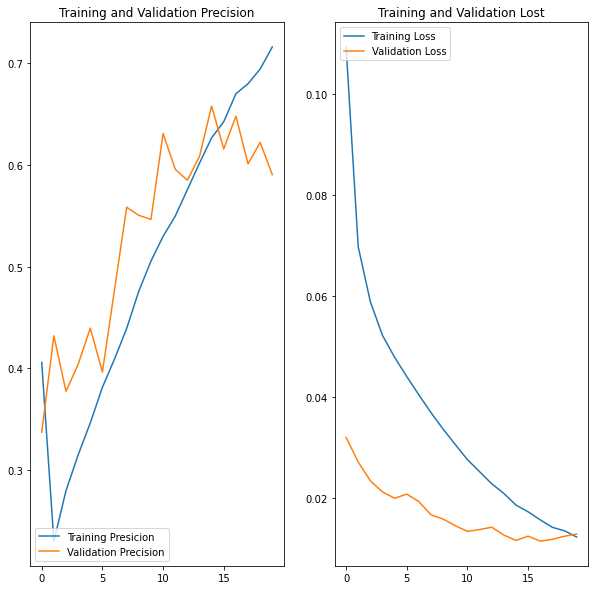

In [63]:
plt.figure(figsize = (10, 10))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), pre, label = 'Training Presicion')
plt.plot(range(EPOCHS), val_pre, label = 'Validation Precision')
plt.legend(loc = 'lower left')
plt.title('Training and Validation Precision')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper left')
plt.title('Training and Validation Lost')
plt.show()

In [49]:
from matplotlib import rcParams

In [50]:
learning_rates = 1e-3 * (10 ** (np.arange(20) / 30))
learning_rates

array([0.001     , 0.00107978, 0.00116591, 0.00125893, 0.00135936,
       0.0014678 , 0.00158489, 0.00171133, 0.00184785, 0.00199526,
       0.00215443, 0.00232631, 0.00251189, 0.00271227, 0.00292864,
       0.00316228, 0.00341455, 0.00368695, 0.00398107, 0.00429866])

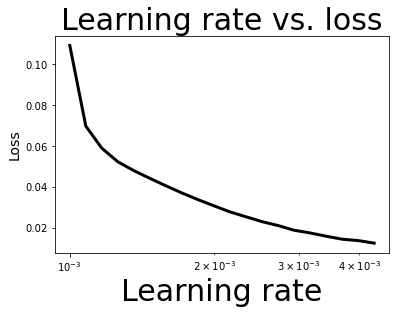

In [64]:
plt.semilogx(
    learning_rates, 
    history.history['loss'], 
    lw=3, color='#000'
)
plt.title('Learning rate vs. loss', size=30)
plt.xlabel('Learning rate', size=30)
plt.ylabel('Loss', size=14);

In [65]:
y_test_images, y_test = tuple(zip( * test_ds))

# # y_test_images = np.array(images, dtype = object)
y_test = np.array(y_test, dtype = object)
y_test = np.concatenate(y_test).ravel().tolist()


In [66]:
predictions = list(model.predict(test_ds))
binary = True
if binary:
    predictions = [np.round(i) for i in predictions]
else:
    predictions = [np.argmax(i) for i in predictions]

936/936 [==============================] - 16s 15ms/step


In [67]:
cm = tf.math.confusion_matrix(labels = y_test, predictions = predictions)

true_negative = cm.numpy()[0][0]
false_positive = cm.numpy()[0][1]
false_negative = cm.numpy()[1][0]
true_positive = cm.numpy()[1][1]

accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
recall = true_positive / (true_positive + false_negative)
precision = true_positive / (true_positive + false_positive)
f1_score = (2 * recall * precision) / (recall + precision)

Accuracy: 0.9965651709401709
Recall: 0.748040313549832
Precision: 0.6151012891344383
F1_score: 0.6750884284992421


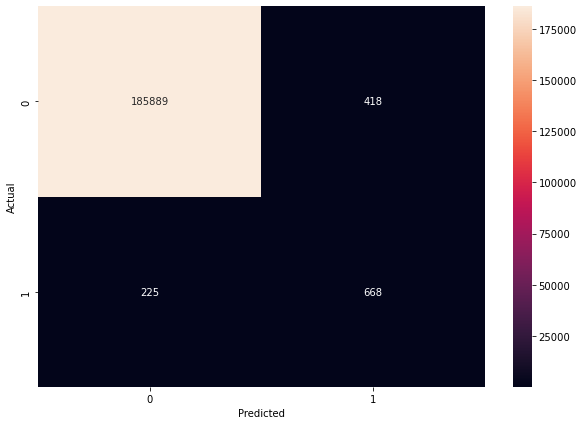

In [68]:
import seaborn as sn
plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

print(f'Accuracy: {accuracy}\nRecall: {recall}\nPrecision: {precision}\nF1_score: {f1_score}')

In [69]:
from sklearn.metrics import classification_report
 
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    186307
           1       0.62      0.75      0.68       893

    accuracy                           1.00    187200
   macro avg       0.81      0.87      0.84    187200
weighted avg       1.00      1.00      1.00    187200



## False Positives

In [70]:
false_positives_idx = []
x = 0
i = 0
while x < 16:
    if predictions[i] == 1 and y_test[i] == 0:
        false_positives_idx.append(i)
        x += 1
    i += 1

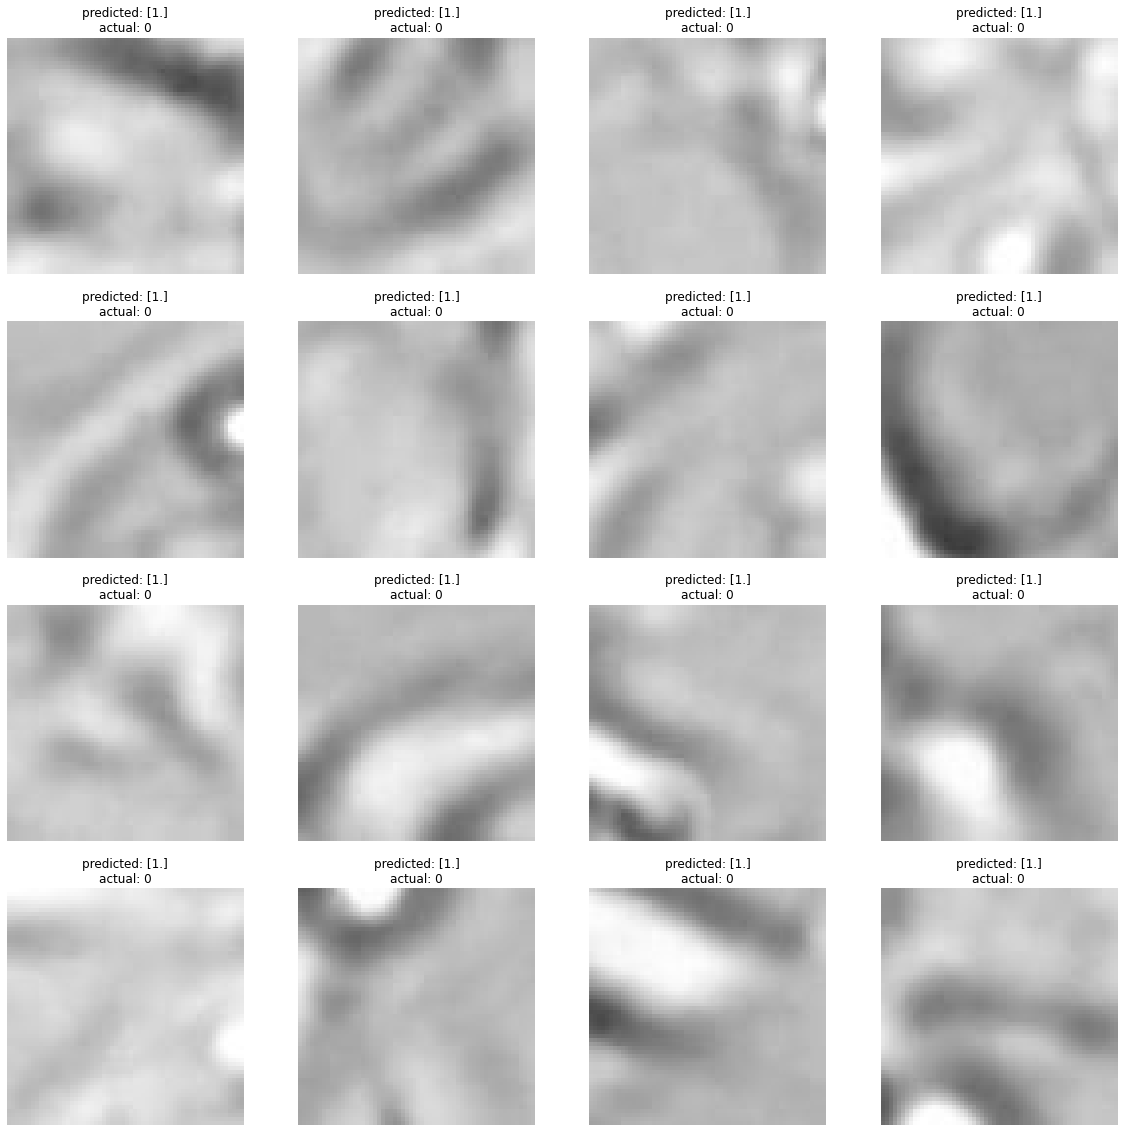

In [71]:
plt.figure(figsize=(20, 20))
i = 0
for idx in false_positives_idx:
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(y_test_images[idx // 200][idx % 200].numpy().astype('uint8'))
    
    predicted_class = predictions[idx]
    actual_class = y_test[idx]
    plt.title(f'predicted: {predicted_class}\nactual: {actual_class}')
    plt.axis('off')
    i += 1